In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from inline_tensorboard import show_graph
from IPython.display import Image

In [2]:
sess = tf.InteractiveSession()

# Generate Data
Let's regenerate the same dataset.

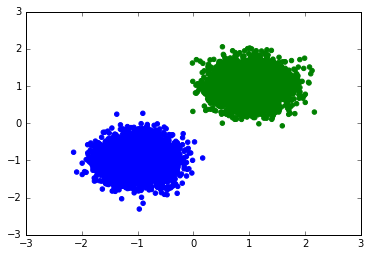

In [3]:
x11, x12 = np.random.multivariate_normal([1, 1], 0.1 * np.eye(2), 5000).T
x21, x22 = np.random.multivariate_normal([-1, -1], 0.1 * np.eye(2), 5000).T

x_ = np.array([np.concatenate([x11, x21]),
              np.concatenate([x12, x22])]).T
y_ = np.array([0] * 5000 + [1] * 5000)

plt.scatter(x_[:,0], x_[:,1], color=['g'] * 5000 + ['b'] * 5000)
plt.show()

# Build the network
We need to construct the network in such a way that it accepts batched inputs and produced a batched output.

In [4]:
x = tf.placeholder(tf.float32, shape=tf.TensorShape([None, 2]), name="input")
y = tf.placeholder(tf.float32, shape=tf.TensorShape([None]), name="input")

In [5]:
initializer = tf.random_uniform_initializer(minval=-np.sqrt(3), maxval=np.sqrt(3))

In [6]:
W1 = tf.get_variable("Weight_1",
                     shape=tf.TensorShape([2, 2]),
                     initializer=initializer,
                     dtype=tf.float32)

b1 = tf.get_variable("bias_1",
                     shape=tf.TensorShape([2]),
                     initializer=initializer,
                     dtype=tf.float32)

W2 = tf.get_variable("Weight_2",
                     shape=tf.TensorShape([2, 1]),
                     initializer=initializer,
                     dtype=tf.float32)

b2 = tf.get_variable("bias_2",
                     shape=tf.TensorShape([1]),
                     initializer=initializer,
                     dtype=tf.float32)

In [7]:
for variable in [W1, W2, b1, b2]:
    variable.initializer.run()

In [8]:
h = tf.nn.sigmoid(tf.matmul(x, W1) + b1)
prediction = tf.squeeze(tf.nn.sigmoid(tf.matmul(h, W2) + b2))

In [9]:
# Construct a "batch" of inputs
batch_indices = np.random.randint(0, 10000, size=64)

placeholder_values = {
    x: x_[batch_indices],
    y: y_[batch_indices]
}

In [10]:
print 'Shape of x:', np.shape(x_[batch_indices])
print 'Shape of y:', np.shape(y_[batch_indices])

Shape of x: (64, 2)
Shape of y: (64,)


# Regularization
Just add the regularizer to the loss term!

In [11]:
beta = 0.01
regularizer = tf.nn.l2_loss(W1) + tf.nn.l2_loss(W2)

In [12]:
loss = (prediction - y) ** 2

In [13]:
print 'Shape of regularizer:', np.shape(regularizer.eval(placeholder_values))
print 'Shape of loss:', np.shape(loss.eval(placeholder_values))

Shape of regularizer: ()
Shape of loss: (64,)


In [14]:
loss = tf.reduce_mean(loss + beta * regularizer)

In [15]:
print 'Shape of loss:', np.shape(loss.eval(placeholder_values))

Shape of loss: ()


# Training
No changes required.

In [16]:
optimizer = tf.train.GradientDescentOptimizer(0.01)
optimize  = optimizer.minimize(loss)

In [17]:
regu_history = []
loss_history = []

for _ in range(10000):
    batch_indices = np.random.randint(0, 10000, size=64)
    placeholder_values = {
        x: x_[batch_indices],
        y: y_[batch_indices]
    }
    
    optimize.run(placeholder_values)
    loss_history.append(np.mean(loss.eval(placeholder_values)))
    regu_history.append(np.mean(regularizer.eval(placeholder_values)))

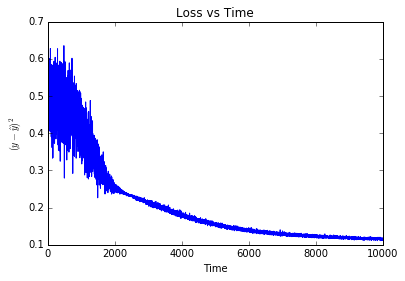

In [18]:
plt.plot(range(len(loss_history)), np.array(loss_history))
plt.xlabel('Time')
plt.ylabel('$(y - \hat{y}) ^ 2$')
plt.title('Loss vs Time')
plt.show()

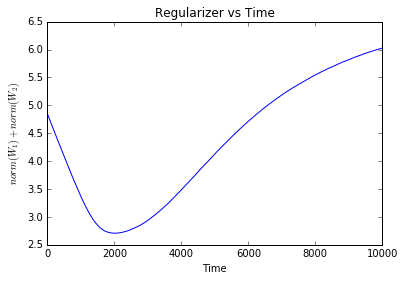

In [19]:
plt.plot(range(len(regu_history)), np.array(regu_history))
plt.xlabel('Time')
plt.ylabel('$norm(W_1) + norm(W_2)$')
plt.title('Regularizer vs Time')
plt.show()

In [20]:
results = []

for index in range(10000):
    placeholder_values = {
        x: np.expand_dims(x_[index], 0)
    }
    
    results.append(prediction.eval(placeholder_values))

In [21]:
print 'Correctly classified', np.count_nonzero(np.squeeze(np.round(results).astype(np.int32)) == y_), '/', len(y_)

Correctly classified 10000 / 10000


# Alternative: Dropout
Randomly set some of the hidden layer units to 0.

In [38]:
# Reset the values
tf.global_variables_initializer().run()

In [39]:
dropout = tf.placeholder(tf.float32)

In [40]:
h = tf.nn.sigmoid(tf.matmul(x, W1) + b1)
h = tf.nn.dropout(h, keep_prob=1-dropout)
prediction = tf.squeeze(tf.nn.sigmoid(tf.matmul(h, W2) + b2))

In [41]:
loss = (prediction - y) ** 2
regularizer = tf.nn.l2_loss(W1) + tf.nn.l2_loss(W2)

In [42]:
optimizer = tf.train.GradientDescentOptimizer(0.01)
optimize  = optimizer.minimize(loss)

In [43]:
regu_history = []
loss_history = []

for _ in range(1000):
    batch_indices = np.random.randint(0, 10000, size=64)
    placeholder_values = {
        dropout: 0.2,
        x: x_[batch_indices],
        y: y_[batch_indices]
    }
    
    optimize.run(placeholder_values)
    loss_history.append(np.mean(loss.eval(placeholder_values)))
    regu_history.append(np.mean(regularizer.eval(placeholder_values)))

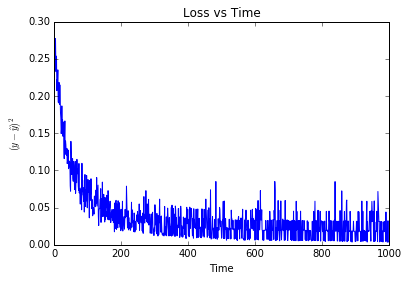

In [44]:
plt.plot(range(len(loss_history)), np.array(loss_history))
plt.xlabel('Time')
plt.ylabel('$(y - \hat{y}) ^ 2$')
plt.title('Loss vs Time')
plt.show()

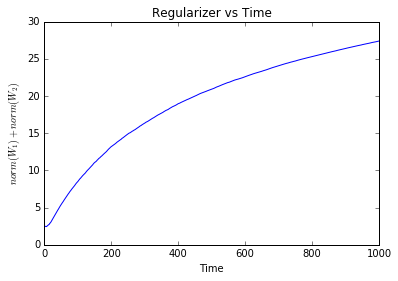

In [45]:
plt.plot(range(len(regu_history)), np.array(regu_history))
plt.xlabel('Time')
plt.ylabel('$norm(W_1) + norm(W_2)$')
plt.title('Regularizer vs Time')
plt.show()

In [46]:
results = []

for index in range(10000):
    placeholder_values = {
        dropout: 0.0,
        x: np.expand_dims(x_[index], 0)
    }
    
    results.append(prediction.eval(placeholder_values))

In [47]:
print 'Correctly classified', np.count_nonzero(np.squeeze(np.round(results).astype(np.int32)) == y_), '/', len(y_)

Correctly classified 10000 / 10000
